<a href="https://colab.research.google.com/github/carlangastr/marketing-science-projects/blob/main/Google_play_reviews_and_NLP_%5BLinkedIn_article%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!DOCTYPE html>
<html>
<body>

<h2><strong>Applying NLP to analyze Google Play Reviews 📃🤖</strong></h2>
<p>Quick introduction to common methods in NLP to analyze text data extracted from Google Play and discover the most regular topics given by the users and their impact on the perception of the different apps.</p>
<p>Powered by: Carlos Trujillo 🚀</p>

</body>
</html>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#We install our libraries

!pip install google-play-scraper
!pip install textblob
!pip install collections
!pip install fasttext

!pip install contractions
!pip install pdpipe

     |████████████████████████████████| 52 kB 1.1 MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-1.0.3-py3-none-any.whl size=24394 sha256=10263c1e85a6bdfd89b6886ffd804c213faa685d884f946c2d8fd71ca75b5a44
  Stored in directory: /root/.cache/pip/wheels/81/37/0b/4a14be55b449a048cd93d79930b1a980dee7896480defa1923
Successfully built google-play-scraper
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
     |████████████████████████████████| 68 kB 3.0 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3144555 sha256=313c87e3596f703d6dc8c8445712a9a09c6ddfc78e2c7b98b5474dbcc5a5ac2c
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 287 kB 5.2 MB

In [ ]:
import pandas as pd
import numpy as np
import pdpipe as pdp

from collections import Counter
from collections import OrderedDict

import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

import fasttext
import contractions

import string

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from google_play_scraper import Sort, reviews

import itertools

from datetime import datetime 

from textblob import TextBlob
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

sns.set(rc={'figure.figsize': (15,10)})

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The Google Play Scrapper library allows you to obtain information about any review within the Google Play Store.

You can read more about this in: https://pypi.org/project/google-play-scraper/

Using this tool we are going to extract the reviews from google play. If we want to process this information, we first need to clean the text of each of the reviews to later empty them into an algorithm. We will create two functions to help us with this.

In [ ]:
#Create functions

def formatear(strings):
    tildes = ['á','é','í','ó','ú']
    vocales = ['a','e','i','o','u']

    # tildes
    for idx, vocal in enumerate(vocales):
        strings = strings.str.replace(tildes[idx],vocal)

    # caracteres especiales menos la ñ
    strings = strings.str.replace('[^a-zñA-Z ]', "")

    # todo a minusculas
    strings = pd.Series(list(map(lambda x: x.lower() if pd.notnull(x) else x, strings)))
    
    return strings

def oracionToStrArr(strings):
    strings_arr = list(map(lambda x: x.split(), strings))
    #pdb.set_trace()
    strings_arr = list(itertools.chain.from_iterable(strings_arr))    
    return strings_arr

In [ ]:
#result, continuation_token = reviews(app, 
#                                       lang='en',
#                                       country='us',
#                                       sort=Sort.MOST_RELEVANT,
#                                       count = 50000,
#                                       filter_score_with = None)

apps = ['com.grability.rappi' ,'com.ubercab.eats']

dataframe = pd.DataFrame()

for app in apps:  
    result, continuation_token = reviews(app, lang='es', country='cl', count = 100000)
    temp = pd.DataFrame(result)
    temp['app'] = app
    dataframe = pd.concat([dataframe, temp])
dataframe.reset_index(inplace = True)

# If you pass `continuation_token` as an argument to the reviews function at this point,
# it will crawl the items after 3 review items.

In [ ]:
#Using pandas we can transform the result into a dataframe
print(dataframe.shape)
print(dataframe.info())

(200000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   index                 200000 non-null  int64         
 1   reviewId              200000 non-null  object        
 2   userName              200000 non-null  object        
 3   userImage             200000 non-null  object        
 4   content               200000 non-null  object        
 5   score                 200000 non-null  int64         
 6   thumbsUpCount         200000 non-null  int64         
 7   reviewCreatedVersion  172408 non-null  object        
 8   at                    200000 non-null  datetime64[ns]
 9   replyContent          29858 non-null   object        
 10  repliedAt             29858 non-null   datetime64[ns]
 11  app                   200000 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(7)
mem

In [ ]:
#we extract only the reviews and apply our functions.

strings = dataframe.content
data_limpia = formatear(strings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


In [ ]:
#after clean our comments we created a new dataframe using only the clean comments.
data_limpia = pd.DataFrame({'content': data_limpia})
data_limpia.content = data_limpia.content.astype('str')

In [ ]:
print(dataframe.shape)
print(data_limpia.shape)

(200000, 12)
(200000, 1)


In [ ]:
dataframe.head(5)

,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app
0,0,gp:AOqpTOG81rFEEq3UHkV56UsRiwWqm-ej_xbD8lHXp1uD8d-cbONobQNX-g5Zmy2lPcU-V_BzEXU-YK5RlPjFbLA,Gregor Grand,https://play-lh.googleusercontent.com/a-/AOh14GhmTy4-kaWZzHwnl6tq93NCgAXZsd3NJZk4VD_dDA,Aunque a veces la App falla pero aún pienso que son los mejores,5,0,7.22.20220420-67400,2022-04-30 20:00:14,None,NaT,com.grability.rappi
1,1,gp:AOqpTOGbhxEWRpG3IPa_DOtyRIiSi8bHIF_fLWXQStM6_rE1h21E1UuYm4FQXr9r6AXDNoSbHYGS5YhryNCblIk,George Bermudez,https://play-lh.googleusercontent.com/a-/AOh14GglFARmgmRpnbtmaQEhQ3YCFEEfPuMrWrNosKfLEQ,Mal servicio y cobran de más.,1,0,7.22.20220420-67400,2022-04-30 19:58:19,None,NaT,com.grability.rappi
2,2,gp:AOqpTOESgDsg2uu7W0gmkegGXHjpDI_sJlTi3xpMk6a-SMB0WQLY-A1pl5425csorc2cCsztvBpZ7dnm7n8ihzk,Diego Mayorga,https://play-lh.googleusercontent.com/a/AATXAJyZETPIKKt35YTJExnJOOHHuG7JPb_b2Uhkh5wm=mo,"Las promociones son una mentiea, dan aununcios se creditos obsequiados y cargados directamente a...",1,0,7.22.20220420-67400,2022-04-30 19:58:01,None,NaT,com.grability.rappi
3,3,gp:AOqpTOHck2hrlt0IUEoZBULzVtbm3N7bVs7xENQpau_6NJVoP6LNA8WYSyzTSVYwLYAfyKWPSZctOfC0uKmD69I,Julio Rene Rojas Bernal,https://play-lh.googleusercontent.com/a/AATXAJztLPKD9ipXN8LQ6qp__rPHxAAijmn1faqhImm5=mo,"Los cobros generados en los pedidos no son del todo claros, ahora tambien incluyen un costo de s...",2,0,7.23.20220422-67429,2022-04-30 19:55:27,None,NaT,com.grability.rappi
4,4,gp:AOqpTOGjU139R9vOPS54XzxXhVr5Fzdbq5yABd9xblKFONJzDwMKXC_Np9Jb4WSNqZjb0MYsNSIQQo5GzNB-yfU,Verónica Hurtado Lima,https://play-lh.googleusercontent.com/a/AATXAJzwab5ly5zAGd1xGT1vKksuBmLcybOUYcJRipzb=mo,Rápido y excelente servicio,5,0,7.23.20220422-67429,2022-04-30 19:55:10,None,NaT,com.grability.rappi


We are going to use an NLP library like Textblob to process the comments and extract the metrics like polarity, subjectivity.

With this we will be able to define if the sentiment of each comment was positive or negative. 

¡A simple lambda function can help us with that!

In [ ]:
data_limpia['polarity'] = data_limpia['content'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
data_limpia['subjectivity'] = data_limpia['content'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)

data_limpia['sent_blop'] = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in data_limpia.polarity]

In [ ]:
print(data_limpia.shape)

(200000, 4)


In [ ]:
filt_dataframe = dataframe[['userName', 'score', 'at', 'app']] #we filter the dataframe to get only the values that we need.
print(filt_dataframe.shape)

(200000, 4)


In [ ]:
data_limpia.dropna(subset = ["content"], inplace=True)
data_limpia.shape

(200000, 4)

In [ ]:
data_comment = pd.concat([data_limpia, filt_dataframe], axis = 1)
print(data_comment.shape)

(200000, 8)


## **¡Change the rules!**

If we examine app reviews, in addition to the main sentiment of the comment, we are interested in knowing how this user rated our app.

For this we create a criterion that in addition to considering the polarity and subjectivity of the comment, assess the score to understand if the general feeling of the review is positive or negative.

In [ ]:
#Let's learn how to apply condition-based filters with pandas.
#We separate the dataframe based on conditions and then concatenate the results.

cond1 = data_comment.score > 3
pos = data_comment[cond1]
pos['final_sentiment'] = 'positive'

cond2 = data_comment.score <= 3
cond3 = data_comment.polarity <= 0.0
neg = data_comment[cond2 & cond3]
neg['final_sentiment'] = 'negative'

cond2 = data_comment.score <= 3
cond3 = data_comment.polarity > 0.0
neu = data_comment[cond2 & cond3]
neu['final_sentiment'] = 'neutral'


table = pd.concat([pos, neu, neg])
print(table.shape) #We verified that we did not lose records.
print(table.info())

table['counter'] = 1

(200000, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199993
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   content          200000 non-null  object        
 1   polarity         200000 non-null  float64       
 2   subjectivity     200000 non-null  float64       
 3   sent_blop        200000 non-null  object        
 4   userName         200000 non-null  object        
 5   score            200000 non-null  int64         
 6   at               200000 non-null  datetime64[ns]
 7   app              200000 non-null  object        
 8   final_sentiment  200000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 15.3+ MB
None


In [ ]:
table['at'] = pd.to_datetime(table['at']).dt.date

In [ ]:
grouped = table[['at', 'app','final_sentiment', 'counter']].groupby(['at', 'app','final_sentiment']).sum()

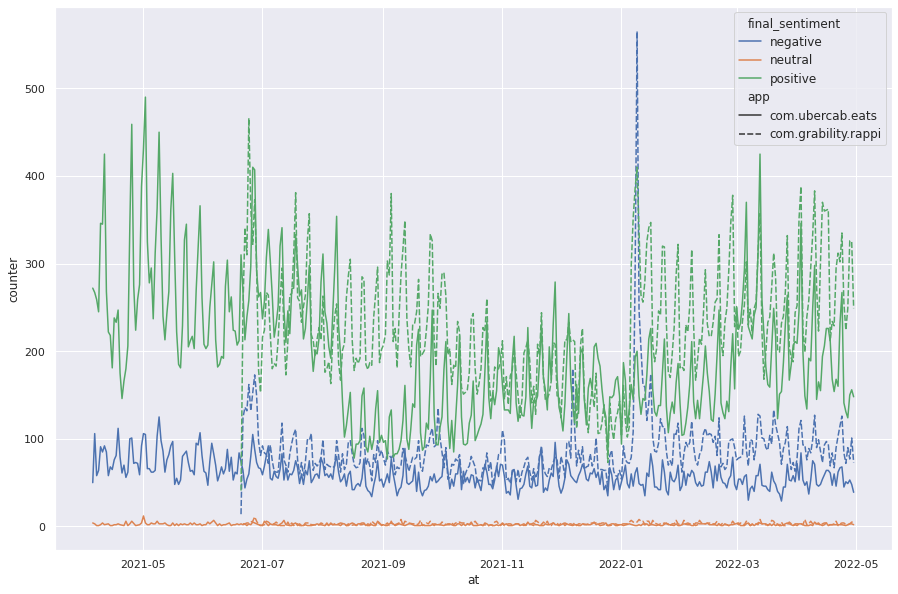

In [ ]:

sns.set(rc={'figure.figsize': (15,10)})
sns.lineplot(data=grouped, 
             x="at", y="counter", hue = 'final_sentiment', style="app")

In [ ]:
grouped.to_csv('/content/drive/MyDrive/NLP/Google Play Store/daily_reviews_app.csv')

###**Center for Systems Science and Engineering (CSSE) at Johns Hopkins University**

We are going to connect to the data obtained from covid by the CSSEGIS.

You can see the information that they have available in the following link:
https://github.com/CSSEGISandData/COVID-19

The data that we will obtain will be the confirmed, recovered and dead cases.

In [ ]:
#We read the info using the path of the public file

confirmed_ts_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_ts_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_ts_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [ ]:
#We use the melt function of pandas to change our dataframes

confirmed_melt = confirmed_ts_df.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'], var_name = 'covid_date', value_name = 'confirmed').copy()
death_melt = deaths_ts_df.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'], var_name = 'covid_date', value_name = 'deaths').copy()
recovered_melt = recovered_ts_df.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'], var_name = 'covid_date', value_name = 'recovered').copy()

#we need to use Pipeline to continue the transformation of our dataframes.

pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['covid_date'], pd.to_datetime),
    pdp.ColRename({'Country/Region': 'country_id', 'Province/State': 'state', 'Lat': 'lat', 'Long': 'long'})
])

confirmed_ts_fcg_df = pipeline.apply(confirmed_melt).sort_values(by=['country_id', 'covid_date'])
deaths_ts_fcg_df = pipeline.apply(death_melt).sort_values(by=['country_id', 'covid_date'])
recovered_ts_fcg_df = pipeline.apply(recovered_melt).sort_values(by=['country_id', 'covid_date'])

#we use the merge function of pandas to combine all the dataframes and centralize the information in one only dataframe.

covid_df = pd.merge(
    pd.merge(confirmed_ts_fcg_df, deaths_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date']),
    recovered_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date'])

In [ ]:
covid_df['new_confirmed'] = covid_df.confirmed - covid_df.confirmed.shift(1)
covid_df['new_confirmed'] = covid_df.new_confirmed.fillna(covid_df.confirmed)

covid_df['new_deaths'] = covid_df.deaths - covid_df.deaths.shift(1)
covid_df['new_deaths'] = covid_df.new_deaths.fillna(covid_df.deaths)

covid_df['new_recovered'] = covid_df.recovered - covid_df.recovered.shift(1)
covid_df['new_recovered'] = covid_df.new_recovered.fillna(covid_df.recovered)

In [ ]:
print(covid_df.info()) #covid_date

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218027 entries, 0 to 218026
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   state          58859 non-null   object        
 1   country_id     218027 non-null  object        
 2   lat            217198 non-null  float64       
 3   long           217198 non-null  float64       
 4   covid_date     218027 non-null  datetime64[ns]
 5   confirmed      218027 non-null  int64         
 6   deaths         218027 non-null  int64         
 7   recovered      218027 non-null  int64         
 8   new_confirmed  218027 non-null  float64       
 9   new_deaths     218027 non-null  float64       
 10  new_recovered  218027 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 20.0+ MB
None


###**Crossing information.**

Now we can plot some time series to see how the increase in cases in our country has behaved with respect to the reviews of our app.

In [ ]:
#set dates
covid_df['covid_date'] = covid_df['covid_date'].astype('str')
covid_df['parse_date'] = pd.to_datetime(covid_df['covid_date'], errors='coerce')
covid_df['parse_date'] = covid_df['parse_date'].dt.strftime('%Y-%m-%d')

table['at'] = table['at'].astype('str')
table['parse_date'] = pd.to_datetime(table['at'], errors='coerce')
table['parse_date'] = table['parse_date'].dt.strftime('%Y-%m-%d')

In [ ]:
temp_covid = covid_df[covid_df.country_id == 'Chile'].groupby('parse_date', as_index = False).sum()
grouped = table[['parse_date', 'app','final_sentiment', 'counter']].groupby(['parse_date', 'app','final_sentiment'], as_index = False).sum()

In [ ]:
print(temp_covid.info())
print(grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   parse_date     829 non-null    object 
 1   lat            829 non-null    float64
 2   long           829 non-null    float64
 3   confirmed      829 non-null    int64  
 4   deaths         829 non-null    int64  
 5   recovered      829 non-null    int64  
 6   new_confirmed  829 non-null    float64
 7   new_deaths     829 non-null    float64
 8   new_recovered  829 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 58.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044 entries, 0 to 2043
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   parse_date       2044 non-null   object
 1   app              2044 non-null   object
 2   final_sentiment  2044 non-null   object
 3   counter 

In [ ]:
visualization = pd.merge(grouped.query("app == 'com.grability.rappi'"), temp_covid[['parse_date','confirmed']], how = 'inner', on = 'parse_date')

<!DOCTYPE html>
<html>
<body>

<!-- Exploratory data analisys header -->

<h2><strong>Understanding the effect of the pandemic over the reviews sentiment 📈 </strong></h2>
<p>Increase in cases and sentiment over time.</p>
<p>app: Rappi</p>

</body>
</html>

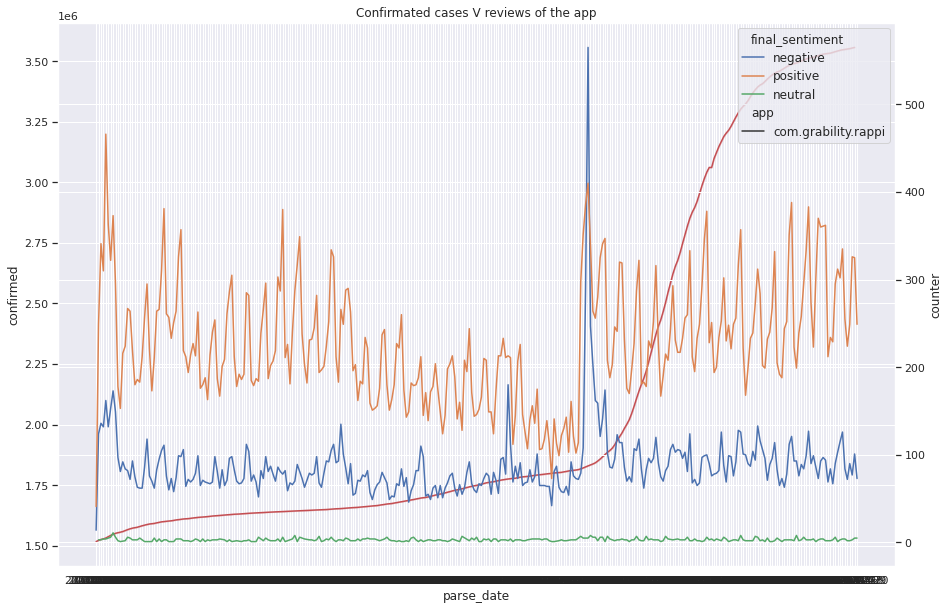

In [ ]:
temp_covid = temp_covid[temp_covid.new_confirmed >= 1]

sns.lineplot(x = 'parse_date', y = 'confirmed', data = visualization, color = 'r')
ax2 = plt.twinx()
sns.lineplot(data=grouped.query("app == 'com.grability.rappi'"), 
             x="parse_date", y="counter", hue = 'final_sentiment', style="app", ax = ax2)

plt.xticks(rotation = 15)
plt.title('Confirmated cases V reviews of the app')
plt.show() # plt.savefig('time_series.png')

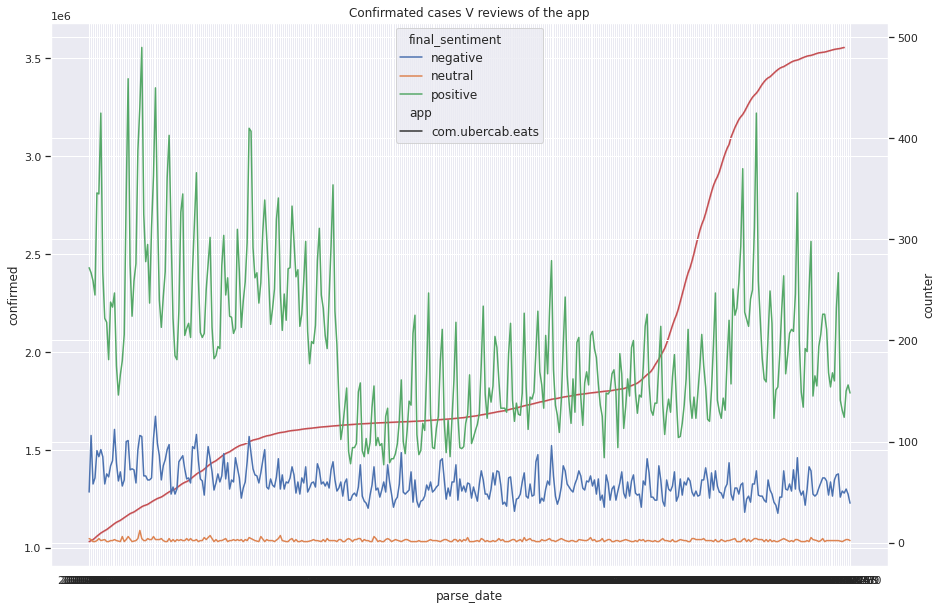

In [ ]:
#com.ubercab.eats

visualization = pd.merge(grouped.query("app == 'com.ubercab.eats'"), temp_covid[['parse_date','confirmed']], how = 'inner', on = 'parse_date')
temp_covid = temp_covid[temp_covid.new_confirmed >= 1]

sns.lineplot(x = 'parse_date', y = 'confirmed', data = visualization, color = 'r')
ax2 = plt.twinx()
sns.lineplot(data=grouped.query("app == 'com.ubercab.eats'"), 
             x="parse_date", y="counter", hue = 'final_sentiment', style="app", ax = ax2)

plt.xticks(rotation = 15)
plt.title('Confirmated cases V reviews of the app')
plt.show() # plt.savefig('time_series.png')

### **Language processing**

Now that we have a little idea about how the situation may be affecting our reviews, let's start to understand how people express themselves around our app.

In [ ]:
## Let's first take a look at our word cloud.

comment_words = '' 
stopwords = set(stopwords.words('spanish'))

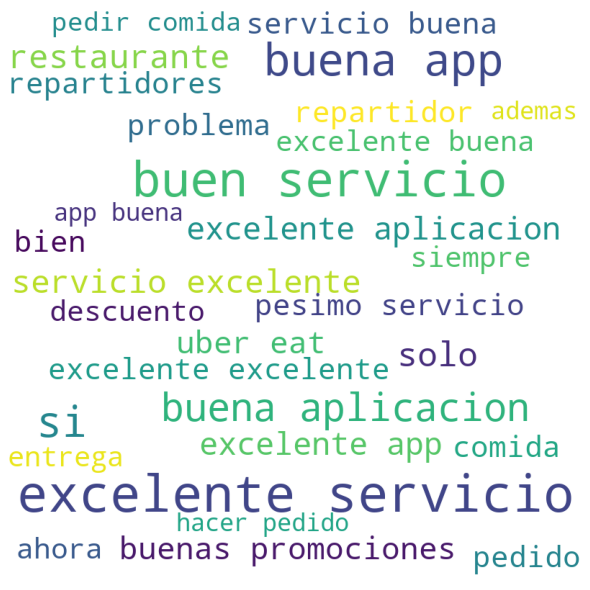

In [ ]:
  
# iterate through the csv file 
for val in table.query("app == 'com.ubercab.eats'").content: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                max_words = 30,
                stopwords = stopwords, 
                min_font_size = 10,
                prefer_horizontal = 1.0).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() #plt.savefig('wordcloud.png')

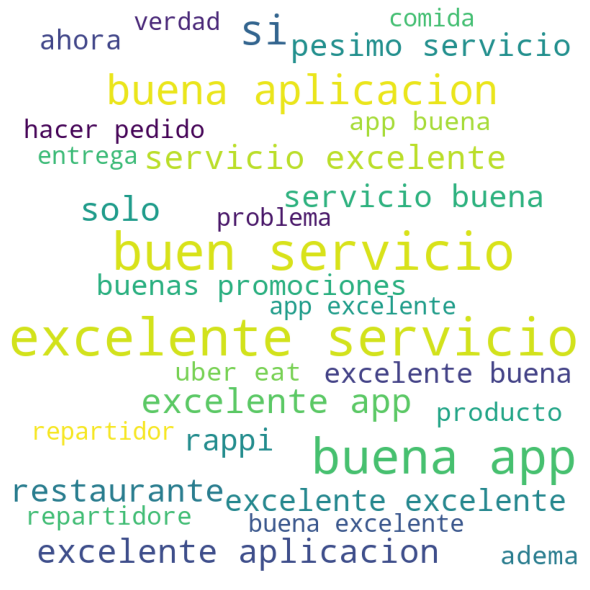

In [ ]:

# iterate through the csv file 
for val in table.query("app == 'com.grability.rappi'").content: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                max_words = 30,
                stopwords = stopwords, 
                min_font_size = 10,
                prefer_horizontal = 1.0).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() #plt.savefig('wordcloud.png')

In [ ]:
# Now let's take a look at the set of most used words in our data set. A great way to look at it is with bigrams.

def plot_top_ngrams_barchart(text, n=2):
    #stop = set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
    #sns.barplot(x=y,y=x).savefig('barplot.png')
#create a function to plot the n-grams

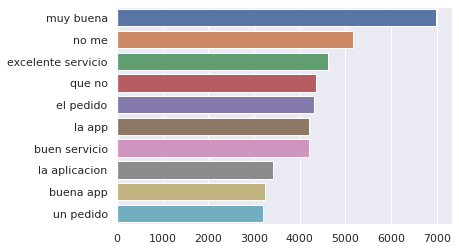

In [ ]:
plot_top_ngrams_barchart(table.query("app == 'com.ubercab.eats'")['content'], 2)

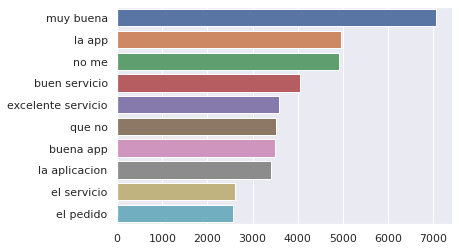

In [ ]:
plot_top_ngrams_barchart(table.query("app == 'com.grability.rappi'")['content'], 2)

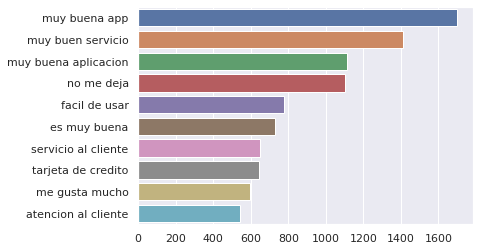

In [ ]:
plot_top_ngrams_barchart(table.query("app == 'com.grability.rappi'")['content'], 3)

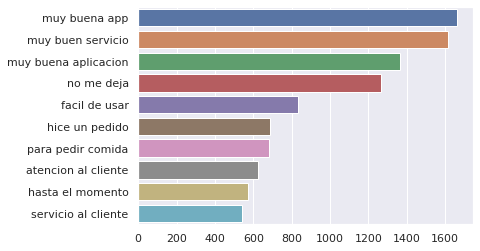

In [ ]:
plot_top_ngrams_barchart(table.query("app == 'com.ubercab.eats'")['content'], 3)

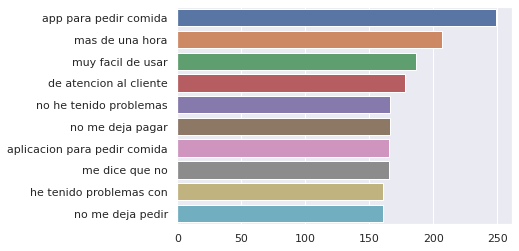

In [ ]:
plot_top_ngrams_barchart(table.query("app == 'com.ubercab.eats'")['content'], 4)

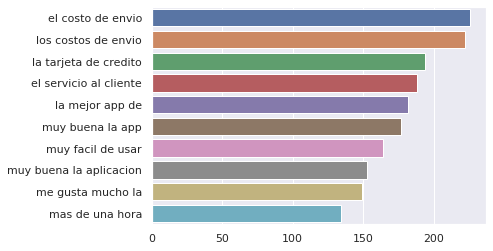

In [ ]:
plot_top_ngrams_barchart(table.query("app == 'com.grability.rappi'")['content'], 4)

In [ ]:
table_temp = table.query("app == 'com.ubercab.eats'").copy()
### We are going to generate different transformations to our reviews to eliminate contractions, punctuation marks and stopwords.
### This will allow us to tokenize our words and later calculate the length of our reviews to cross that information.

table_temp['no_contract'] = table_temp['content'].apply(lambda x: [contractions.fix(word) for word in x.split()])

table_temp['rating_description_str'] = [' '.join(map(str, l)) for l in table_temp['no_contract']]

table_temp['tokenized'] = table_temp['rating_description_str'].apply(word_tokenize)

table_temp['lower'] = table_temp['tokenized'].apply(lambda x: [word.lower() for word in x])

punc = string.punctuation
table_temp['no_punc'] = table_temp['lower'].apply(lambda x: [word for word in x if word not in punc])

#stop_words = set(stopwords.words('english'))
table_temp['stopwords_removed'] = table_temp['no_punc'].apply(lambda x: [word for word in x if word not in stopwords])

table_temp['pos_tags'] = table_temp['stopwords_removed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

table_temp['wordnet_pos'] = table_temp['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
table_temp['lemmatized'] = table_temp['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
table_temp['lemma_str'] = [' '.join(map(str,l)) for l in table_temp['lemmatized']]


table_temp['word_count'] = table_temp['lemmatized'].apply(lambda x: len(str(x).split()))
table_temp['review_len'] = table_temp['lemma_str'].astype(str).apply(len)

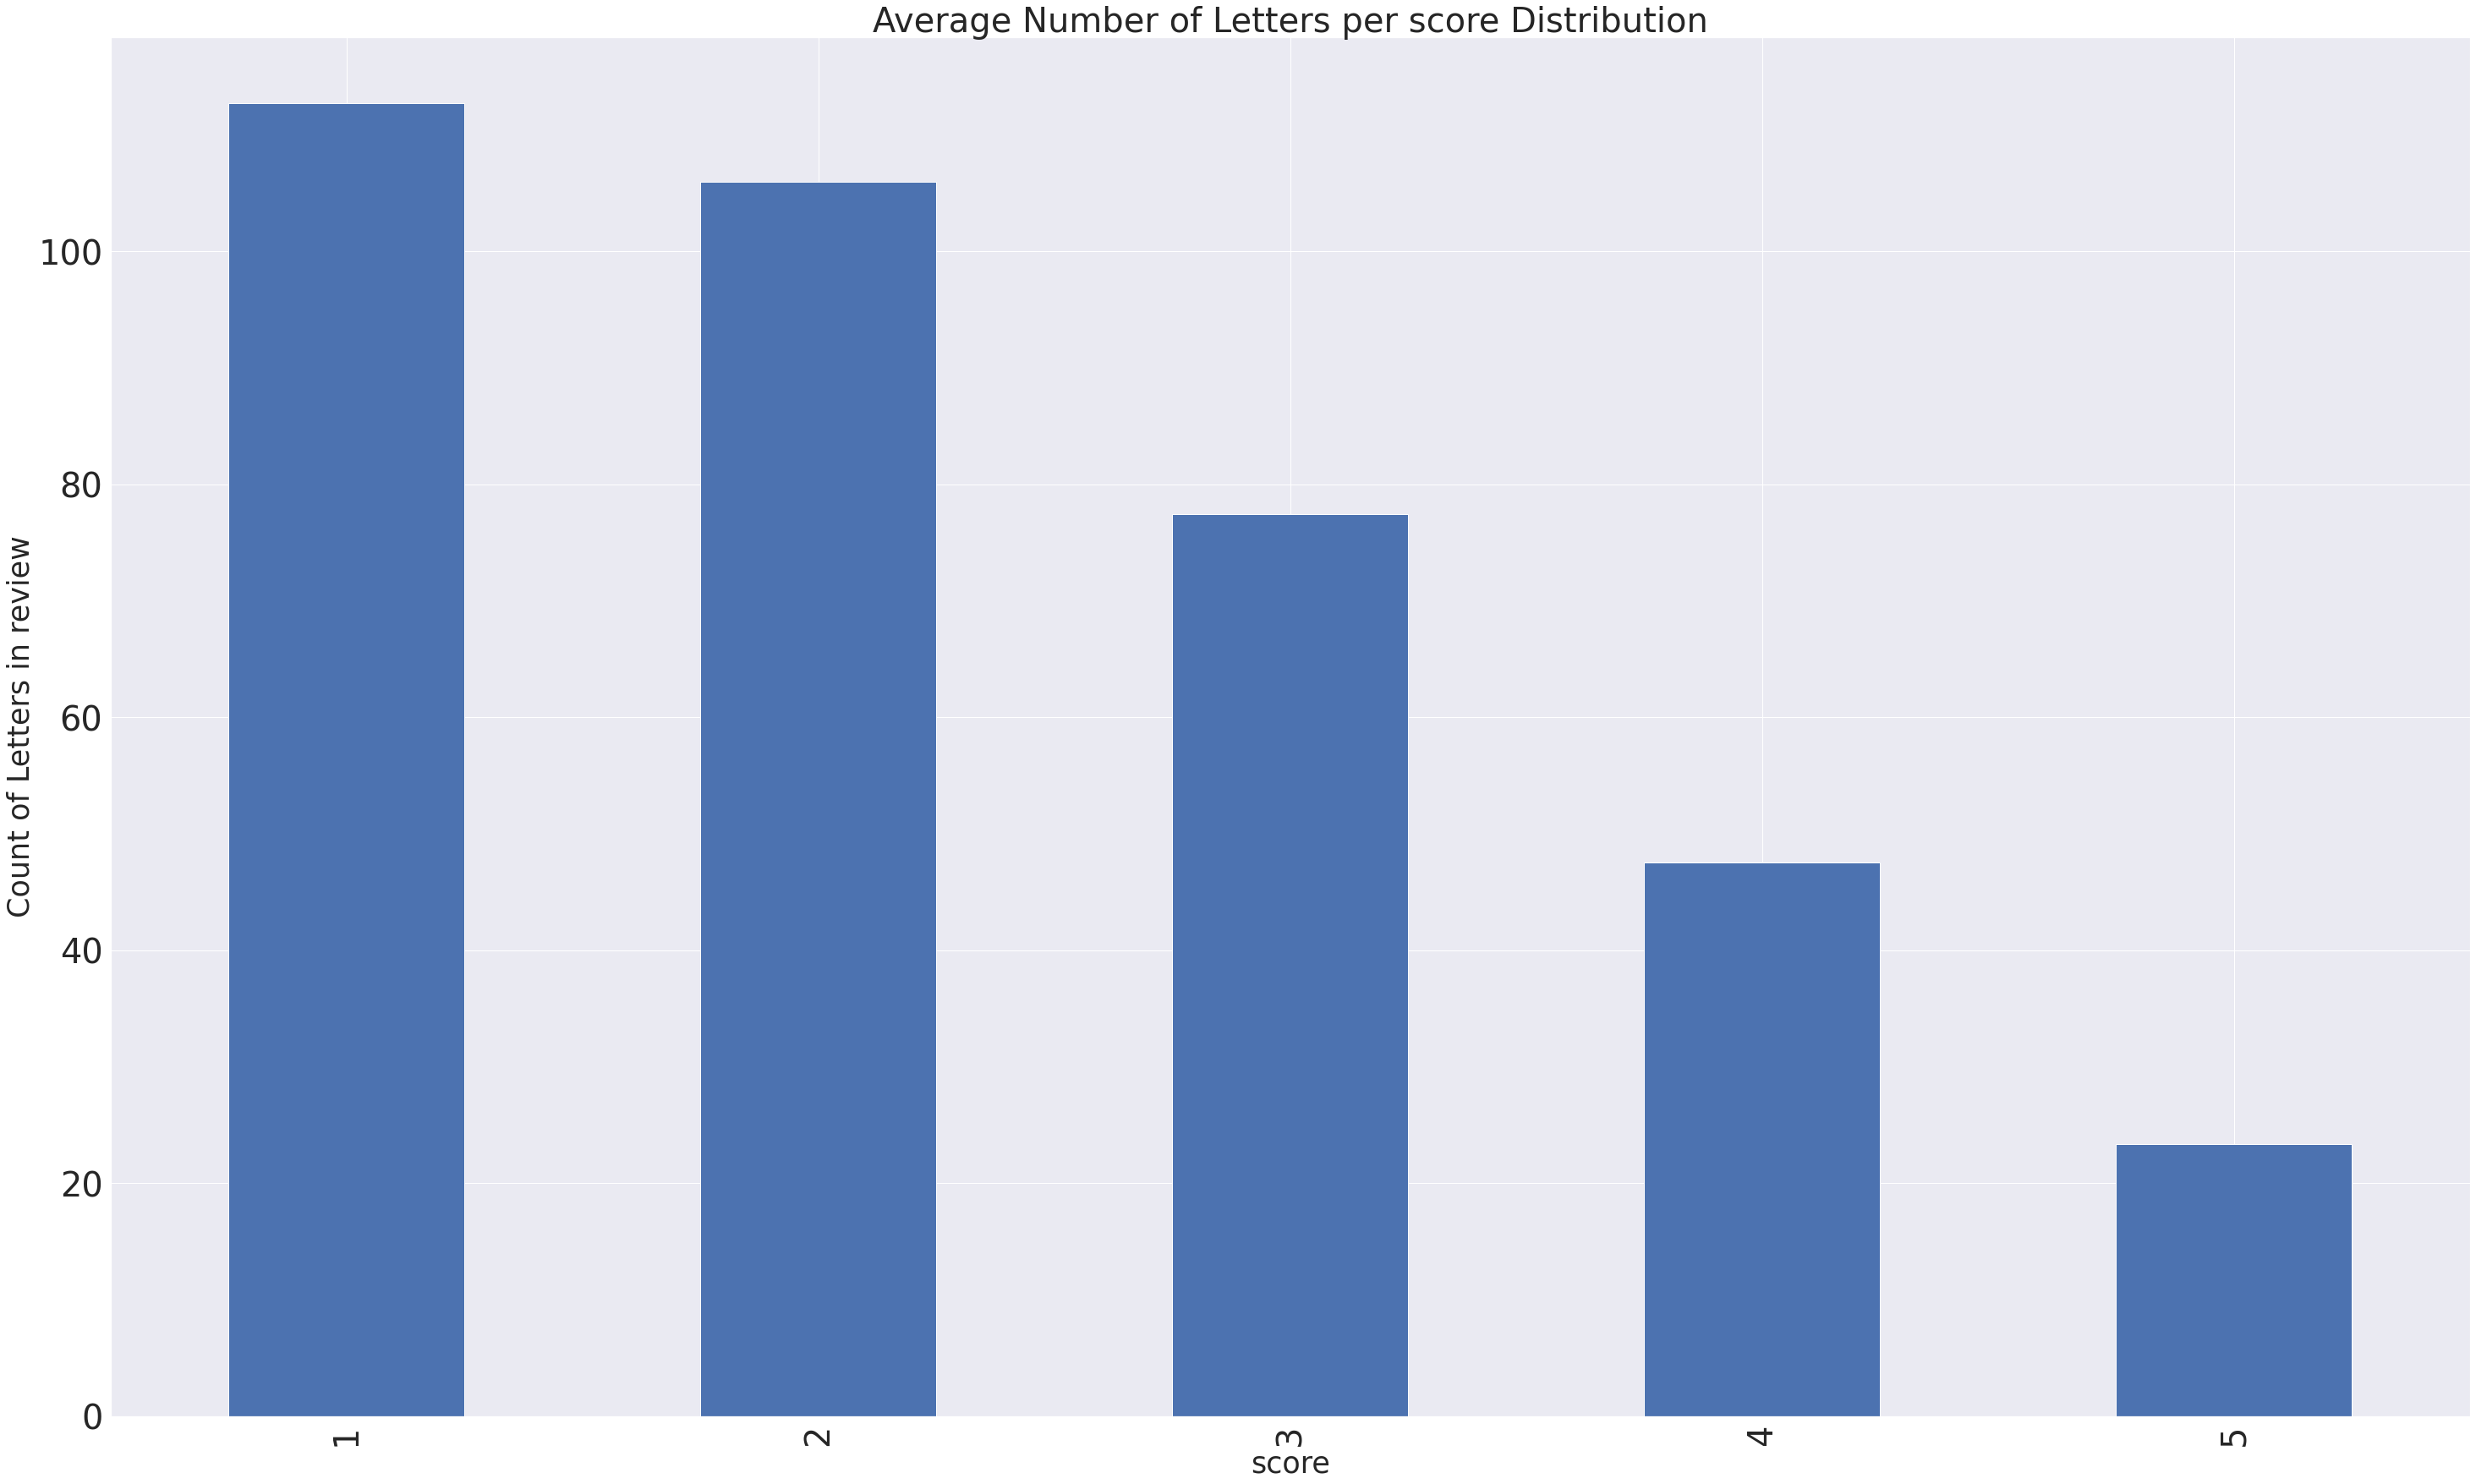

In [ ]:
letter_avg = table_temp.groupby('score')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('score', fontsize=35)
plt.ylabel('Count of Letters in review', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per score Distribution', fontsize=40)
plt.show() # plt.savefig('barchart_temp.png')

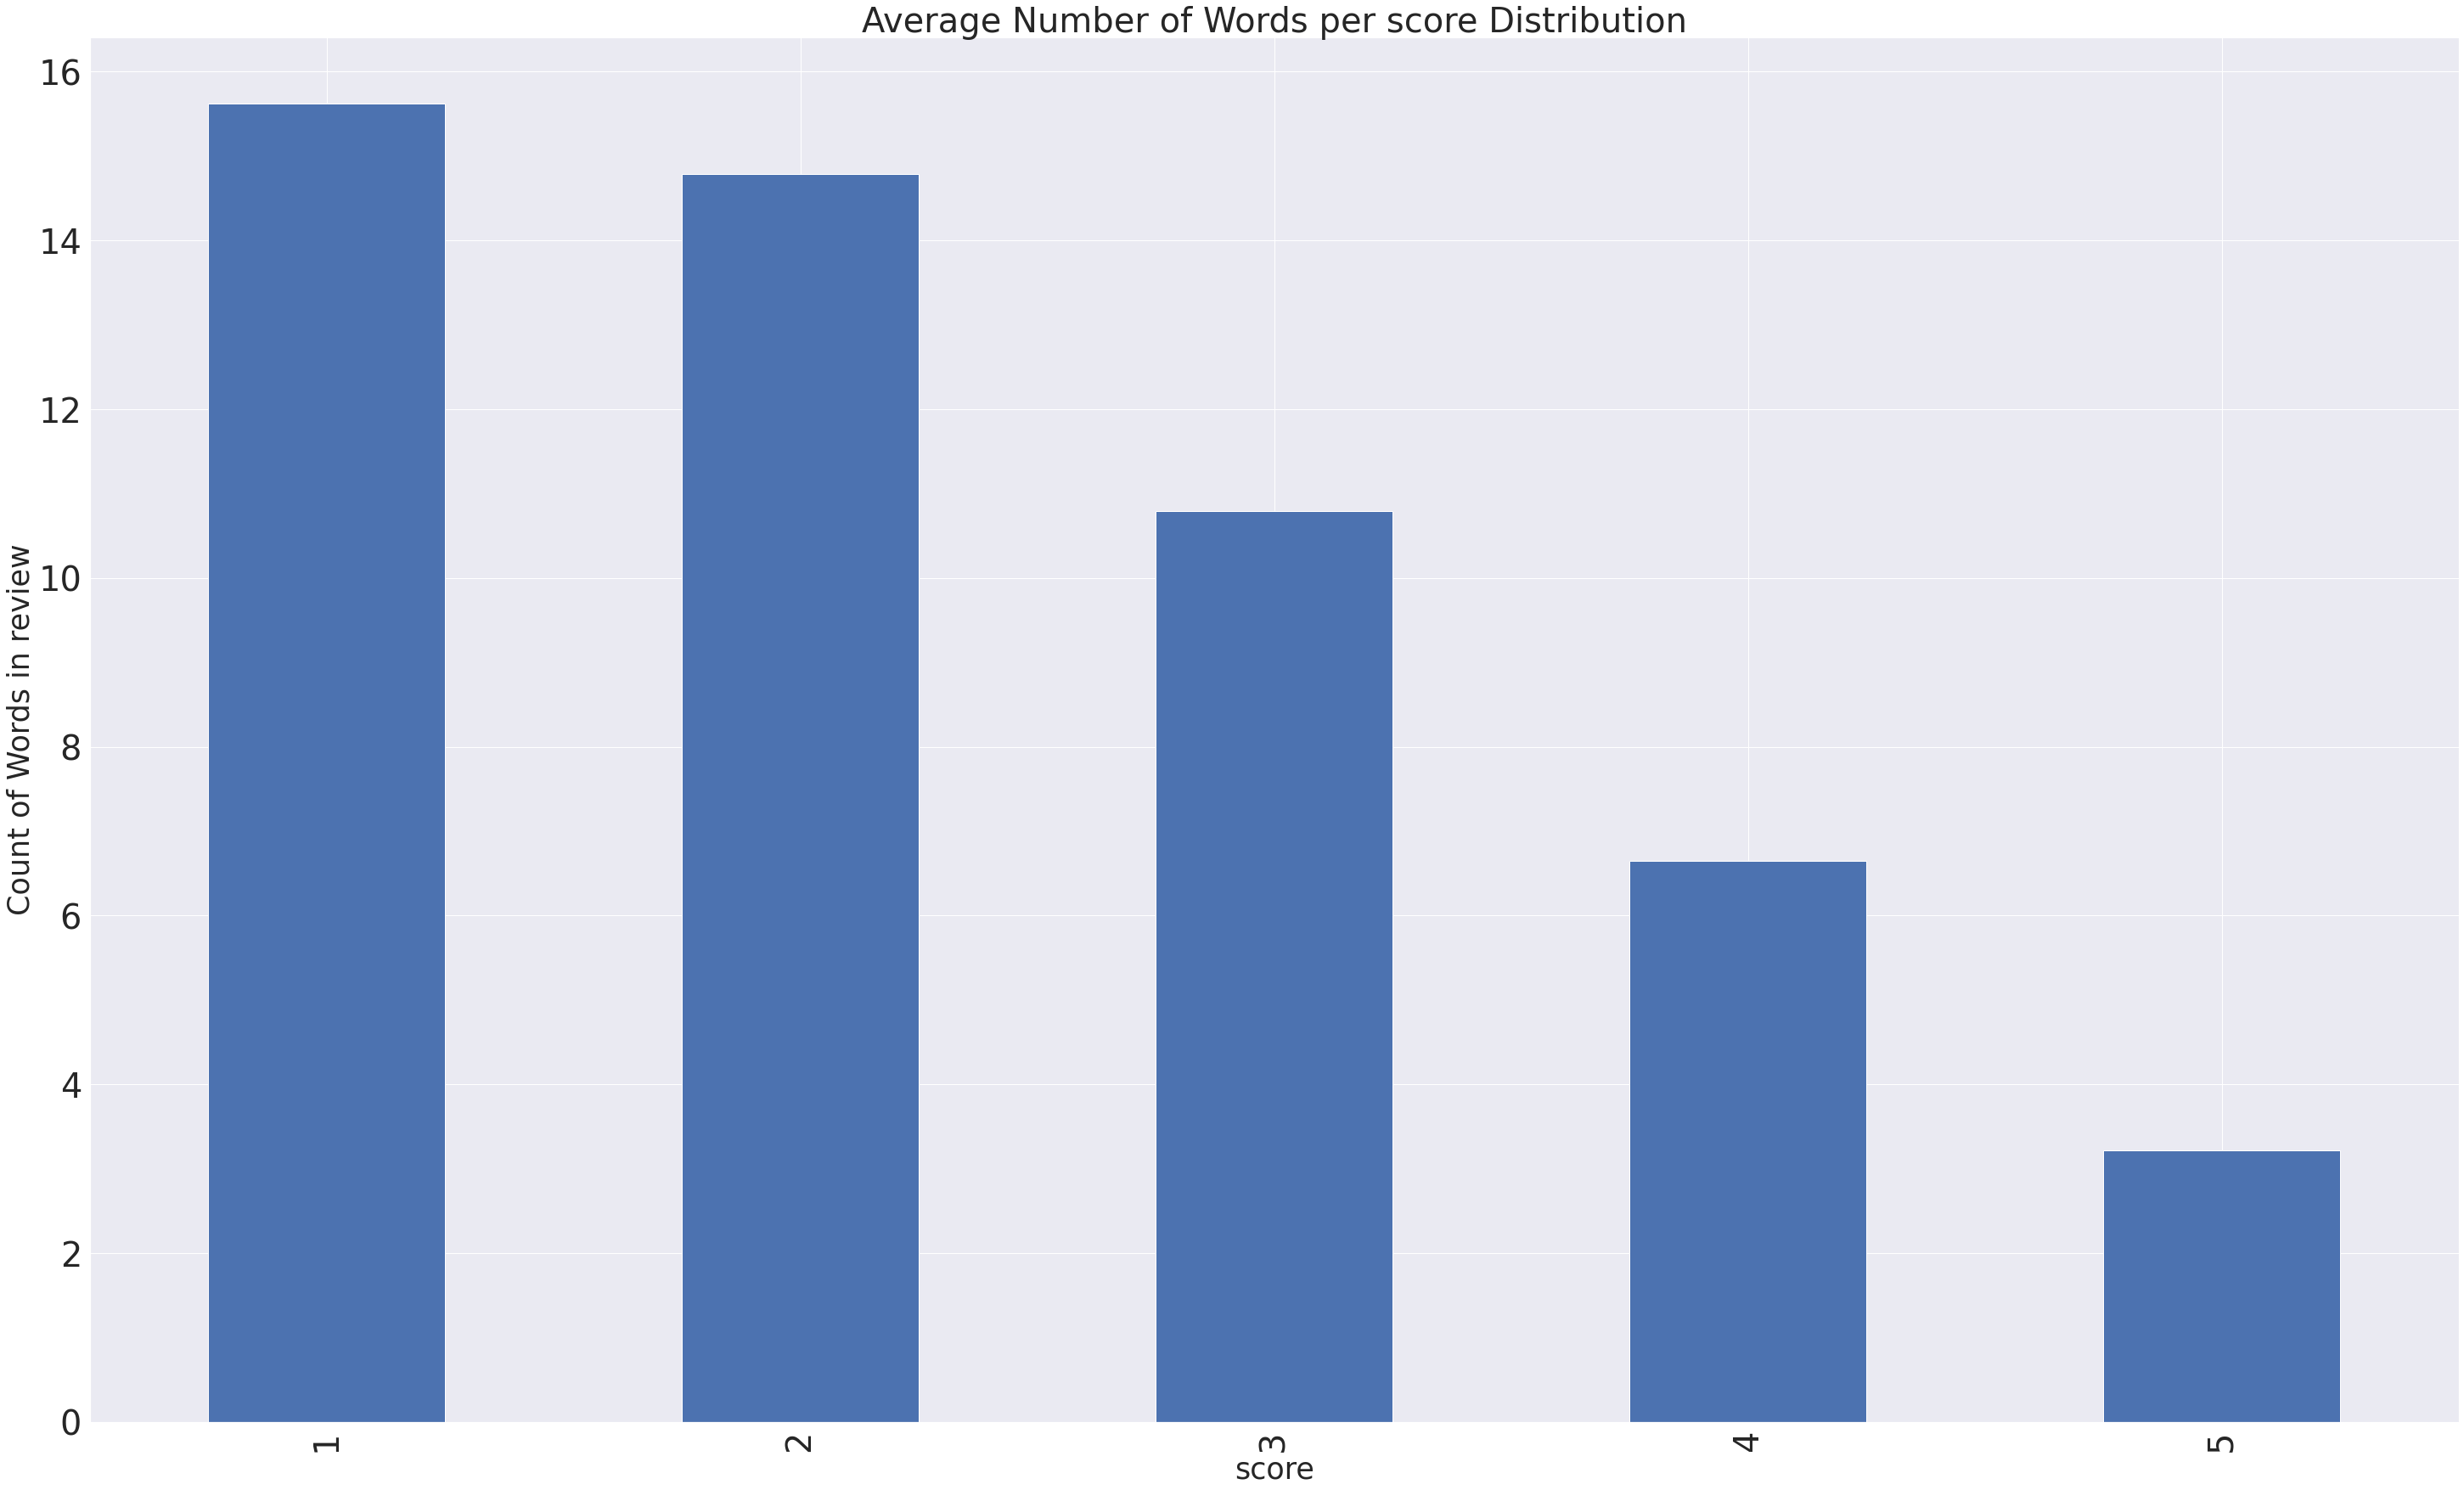

In [ ]:

word_avg = table_temp.groupby('score')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('score', fontsize=35)
plt.ylabel('Count of Words in review', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per score Distribution', fontsize=40)
plt.show() # plt.savefig('barchart.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


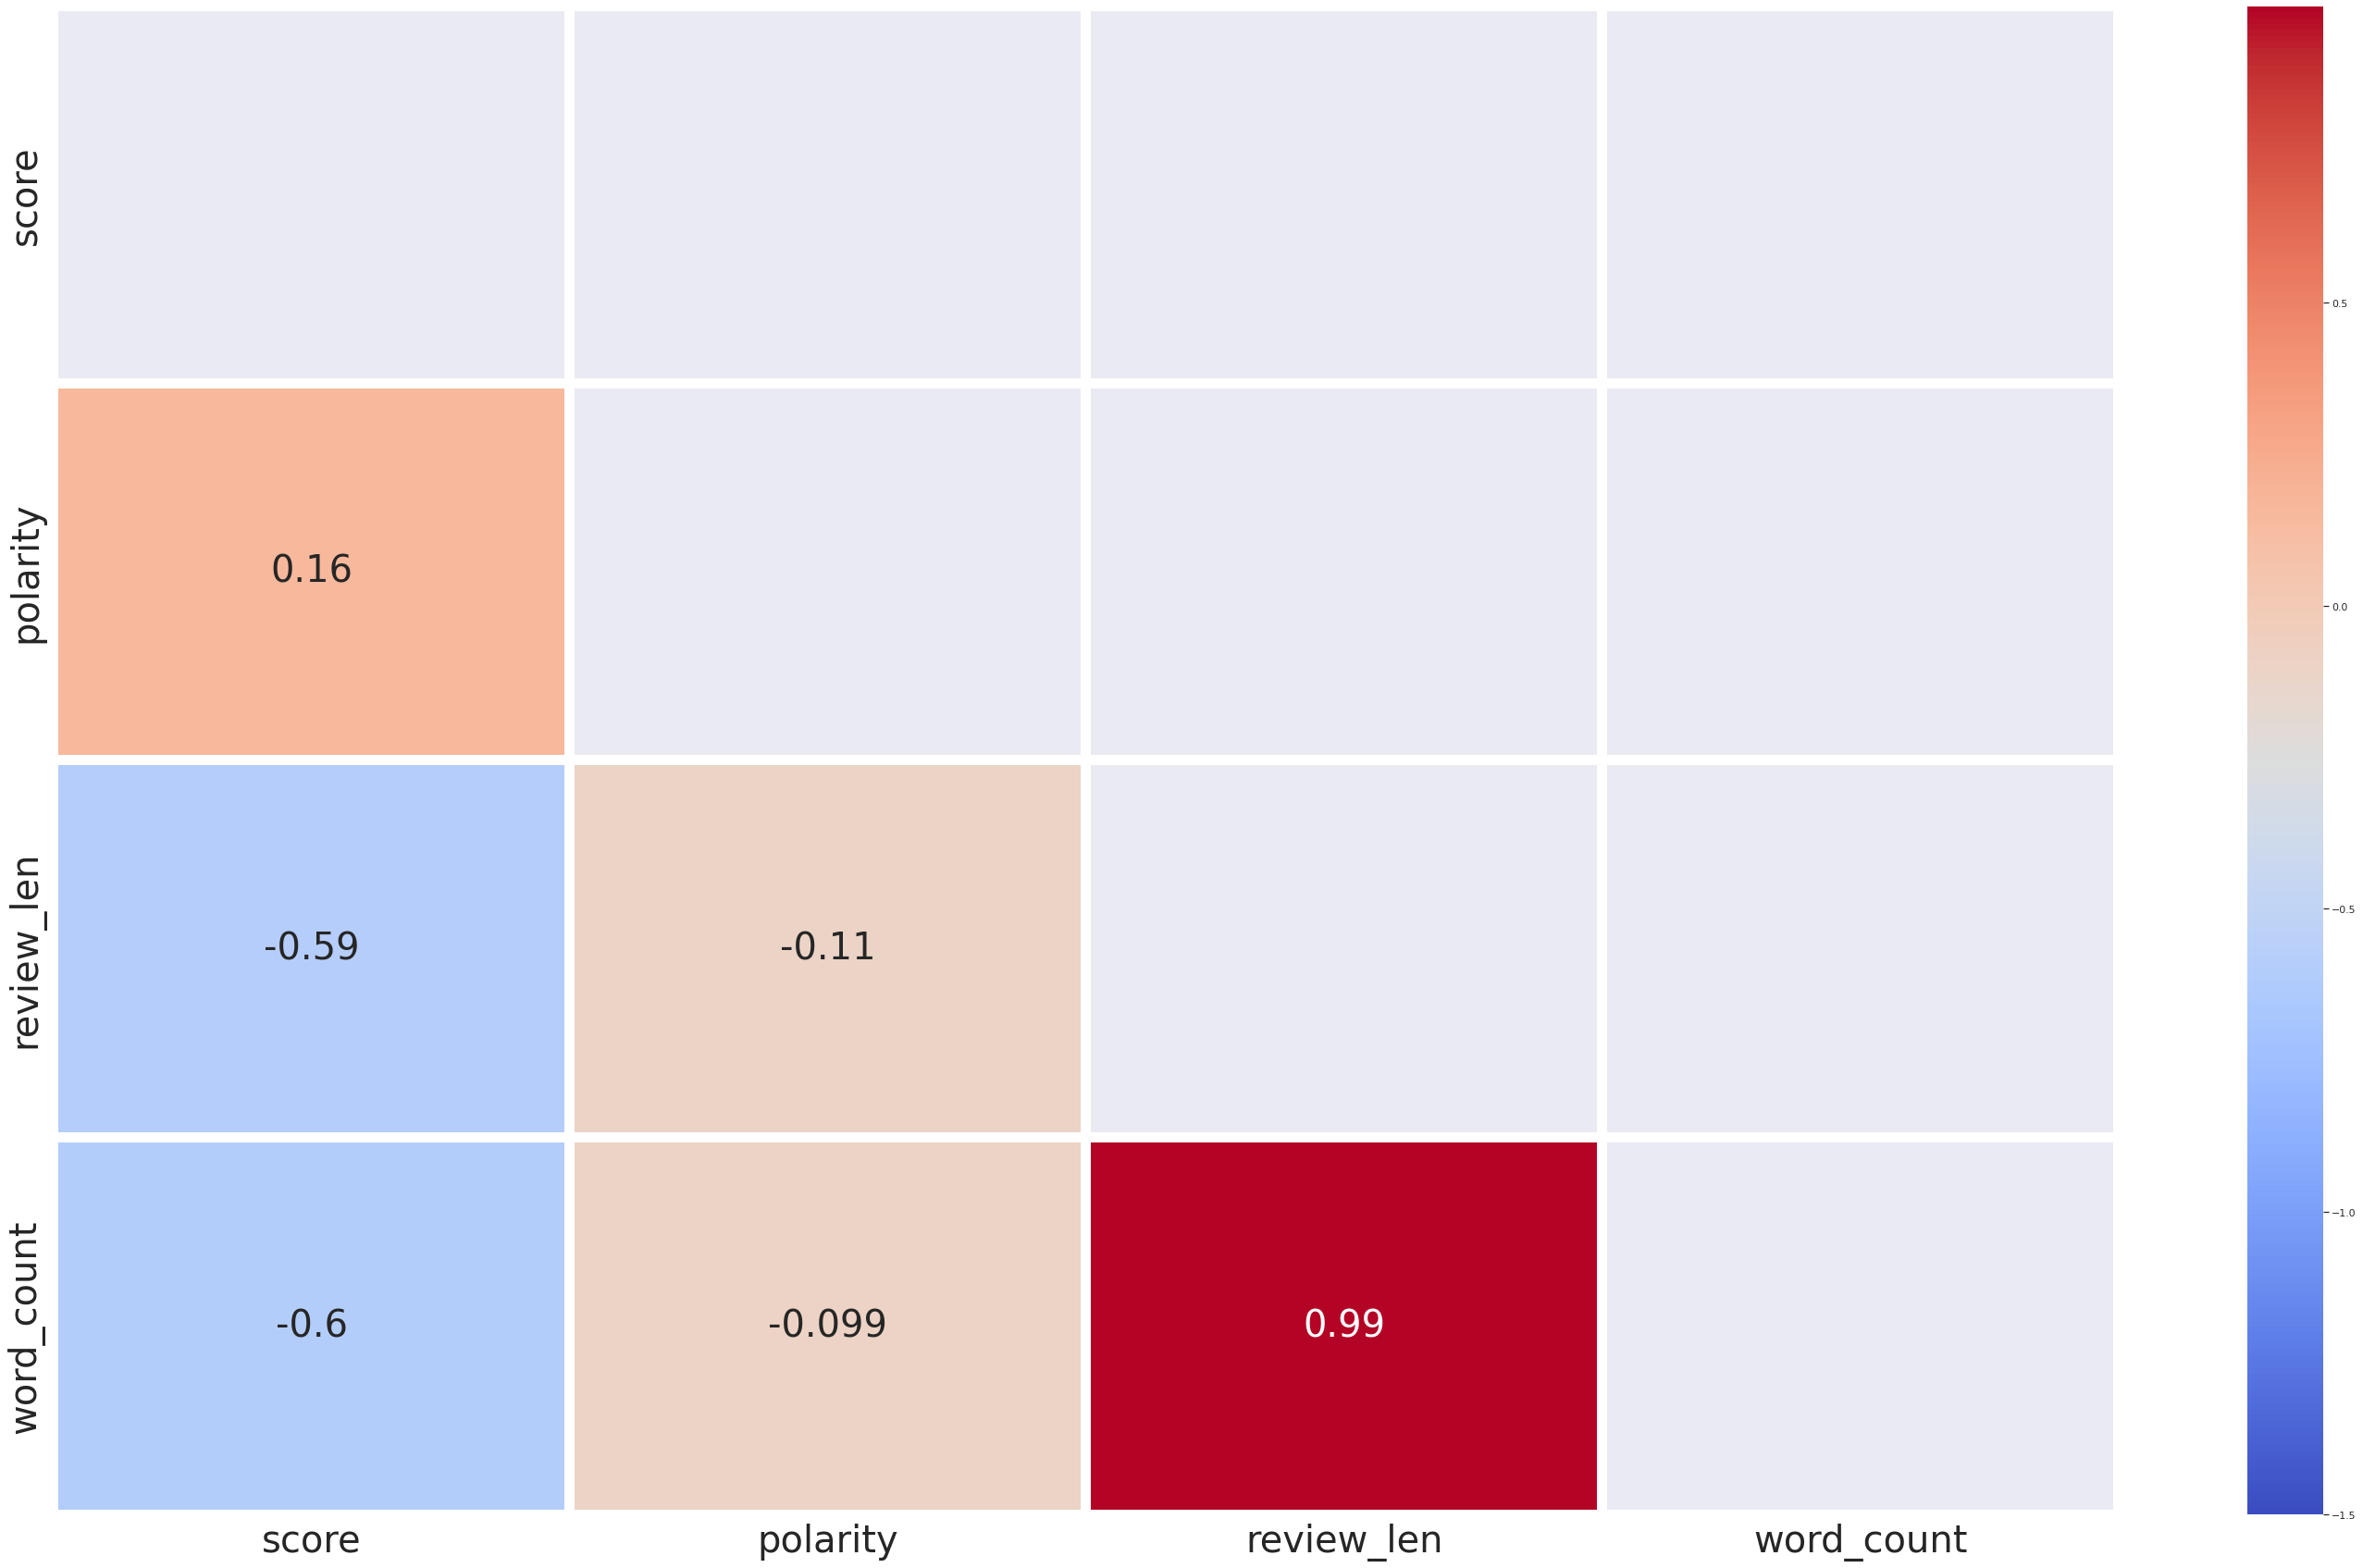

In [ ]:
## Creating a matrix correlation for the words and sentiment

correlation = table_temp[['score','polarity', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)
#sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask).savefig('map.png')

In [ ]:
table_temp = table.query("app == 'com.grability.rappi'").copy()
### We are going to generate different transformations to our reviews to eliminate contractions, punctuation marks and stopwords.
### This will allow us to tokenize our words and later calculate the length of our reviews to cross that information.

table_temp['no_contract'] = table_temp['content'].apply(lambda x: [contractions.fix(word) for word in x.split()])

table_temp['rating_description_str'] = [' '.join(map(str, l)) for l in table_temp['no_contract']]

table_temp['tokenized'] = table_temp['rating_description_str'].apply(word_tokenize)

table_temp['lower'] = table_temp['tokenized'].apply(lambda x: [word.lower() for word in x])

punc = string.punctuation
table_temp['no_punc'] = table_temp['lower'].apply(lambda x: [word for word in x if word not in punc])

#stop_words = set(stopwords.words('english'))
table_temp['stopwords_removed'] = table_temp['no_punc'].apply(lambda x: [word for word in x if word not in stopwords])

table_temp['pos_tags'] = table_temp['stopwords_removed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

table_temp['wordnet_pos'] = table_temp['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
table_temp['lemmatized'] = table_temp['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
table_temp['lemma_str'] = [' '.join(map(str,l)) for l in table_temp['lemmatized']]


table_temp['word_count'] = table_temp['lemmatized'].apply(lambda x: len(str(x).split()))
table_temp['review_len'] = table_temp['lemma_str'].astype(str).apply(len)

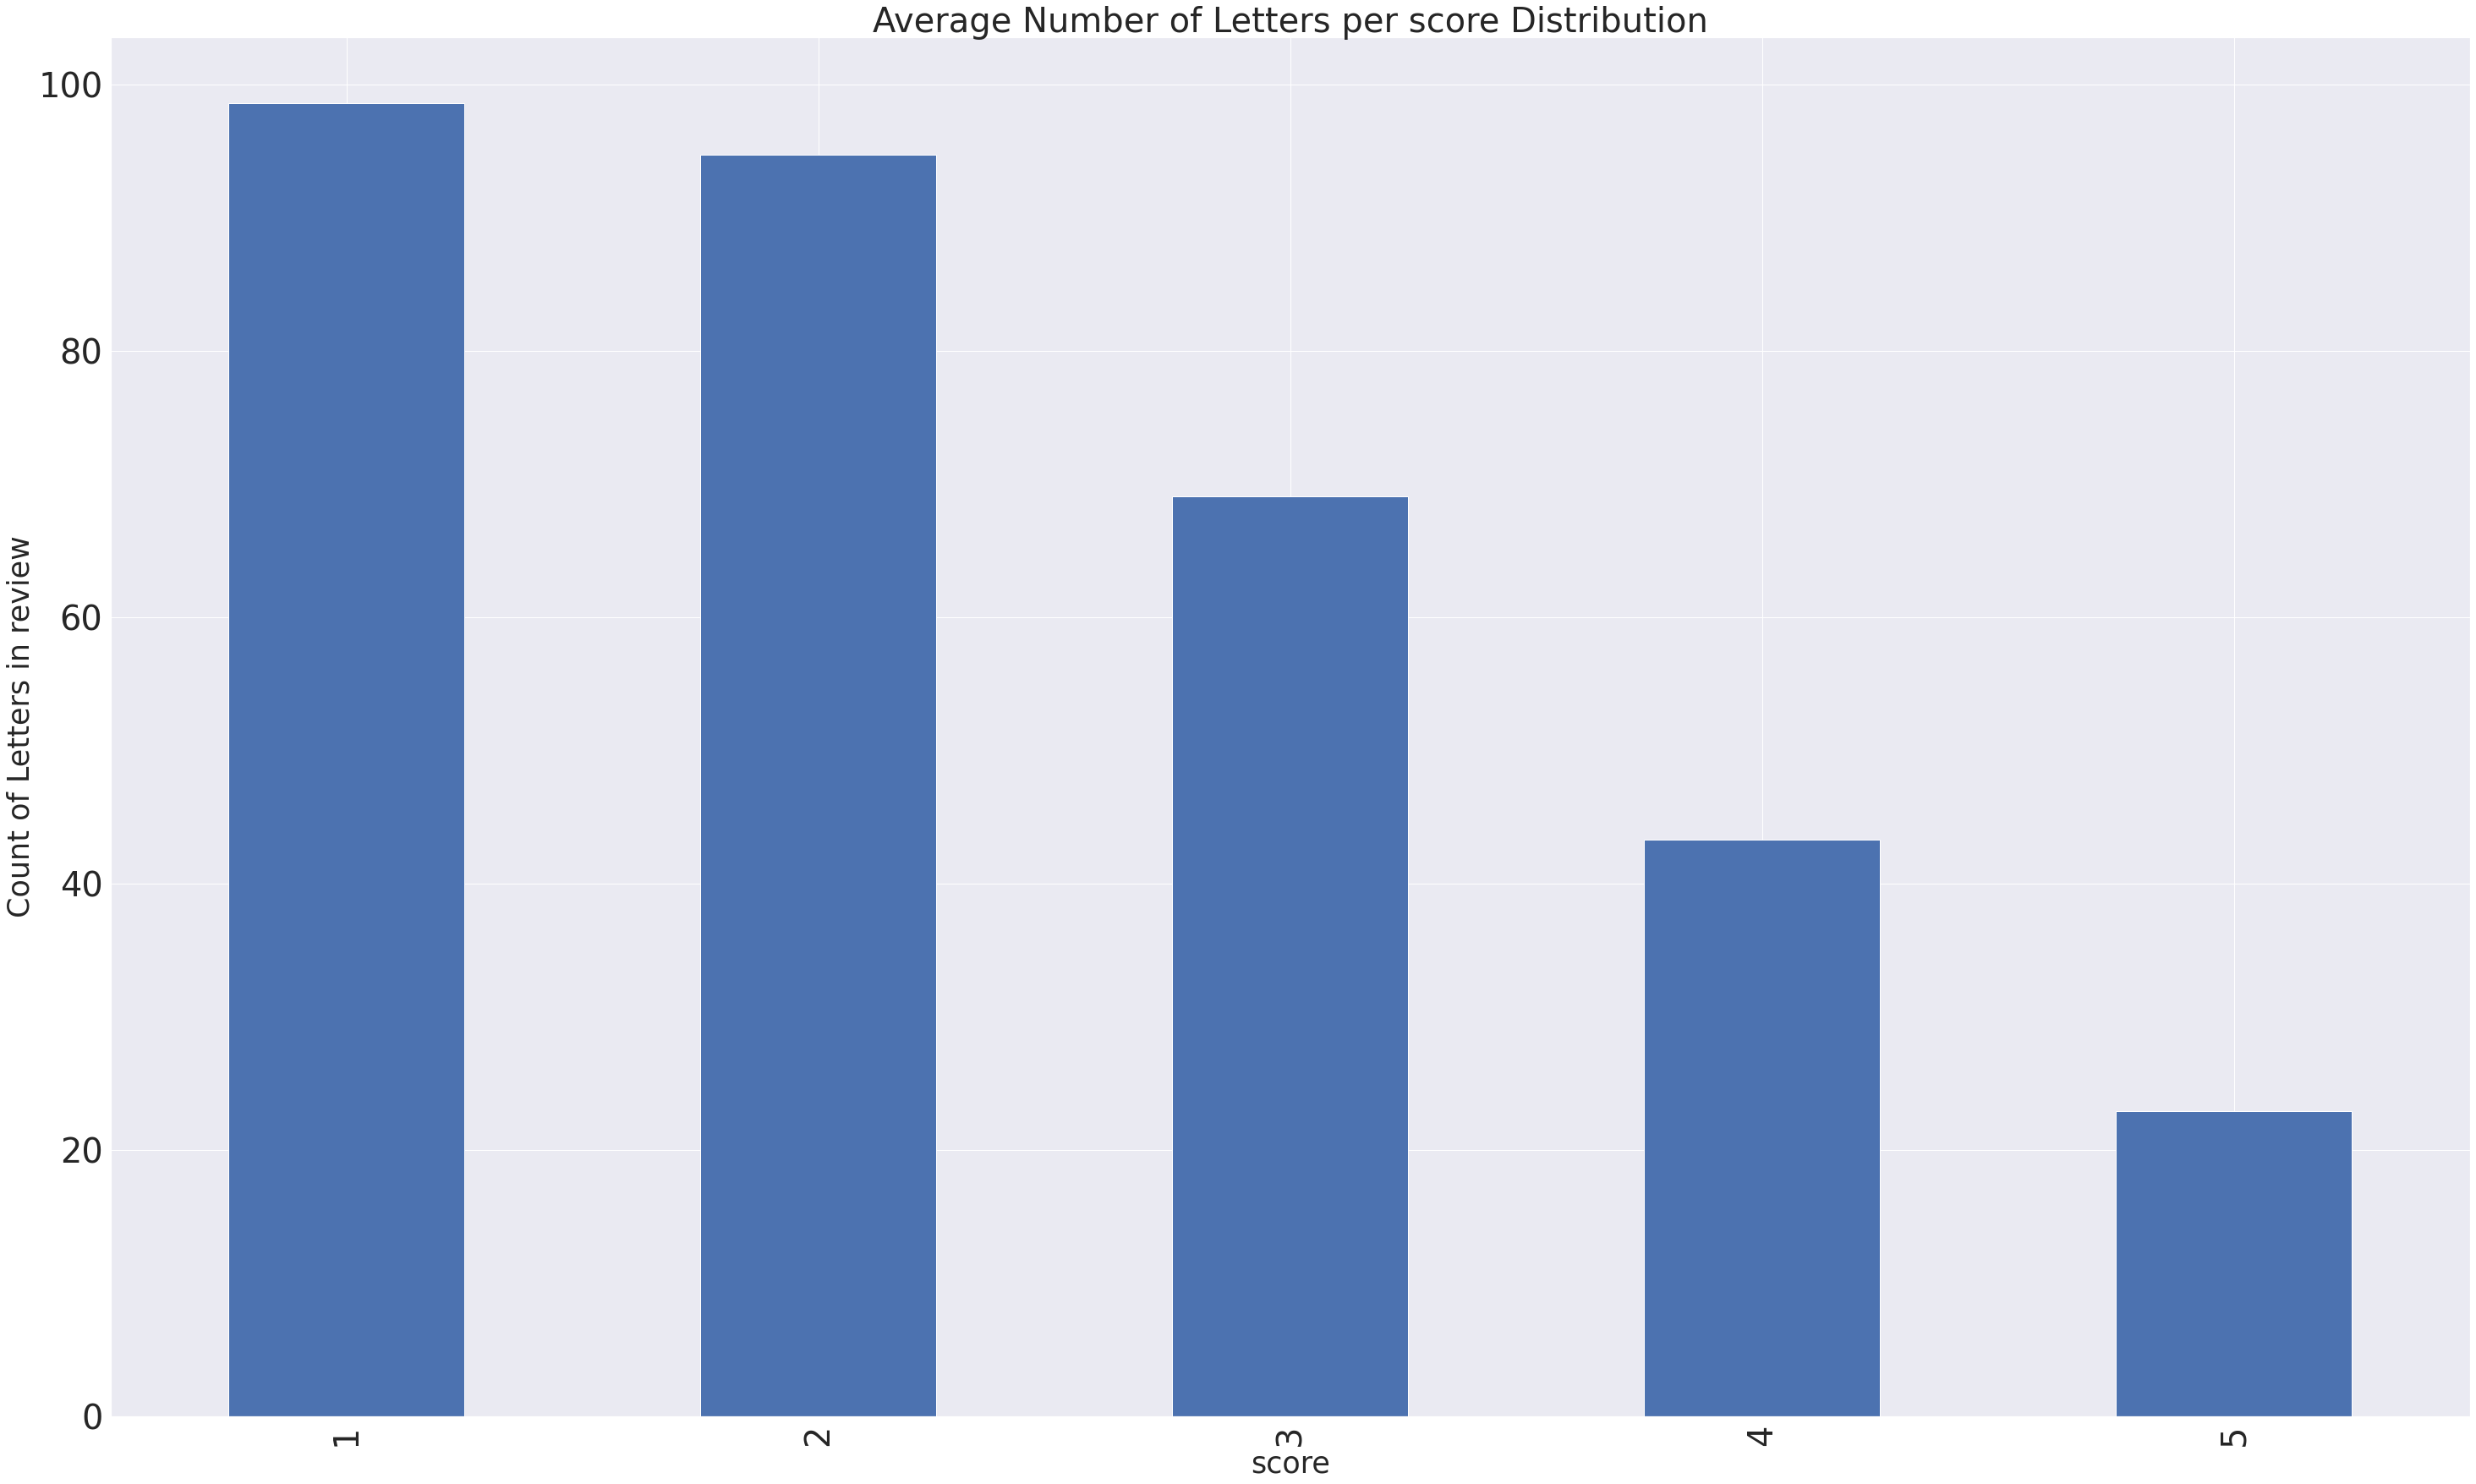

In [ ]:
letter_avg = table_temp.groupby('score')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('score', fontsize=35)
plt.ylabel('Count of Letters in review', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per score Distribution', fontsize=40)
plt.show() # plt.savefig('barchart_temp.png')

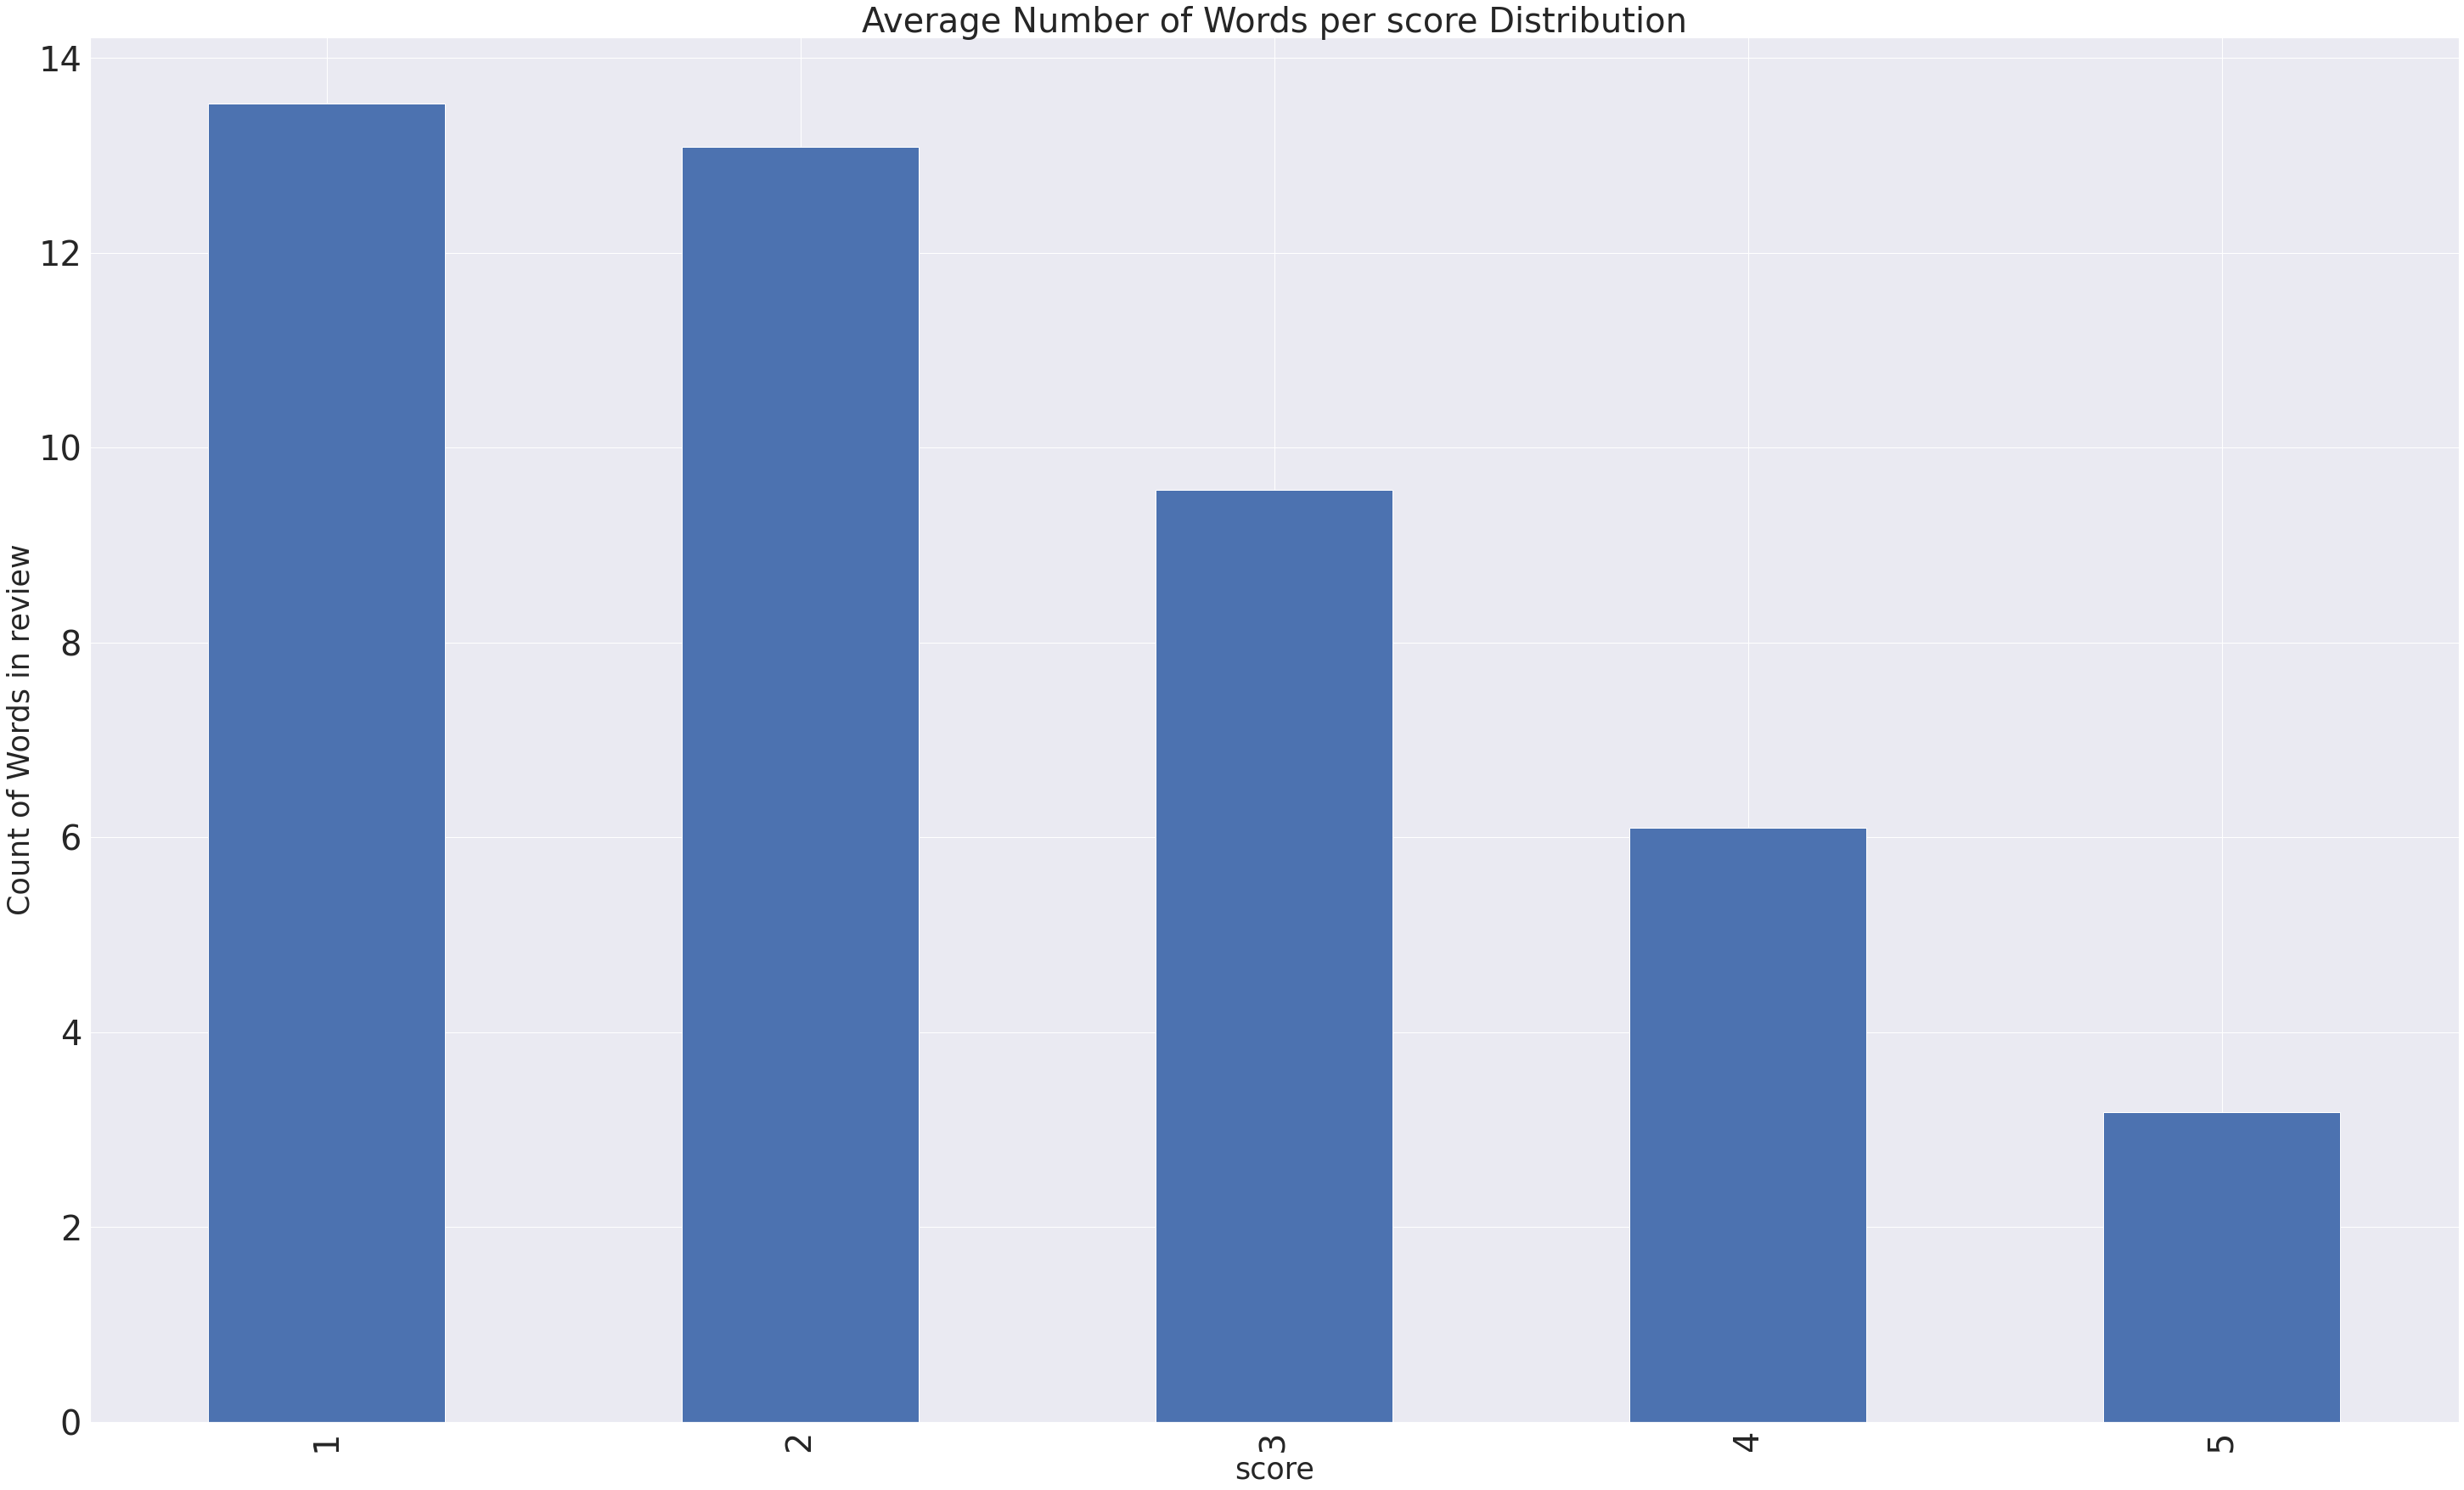

In [ ]:

word_avg = table_temp.groupby('score')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('score', fontsize=35)
plt.ylabel('Count of Words in review', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per score Distribution', fontsize=40)
plt.show() # plt.savefig('barchart.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


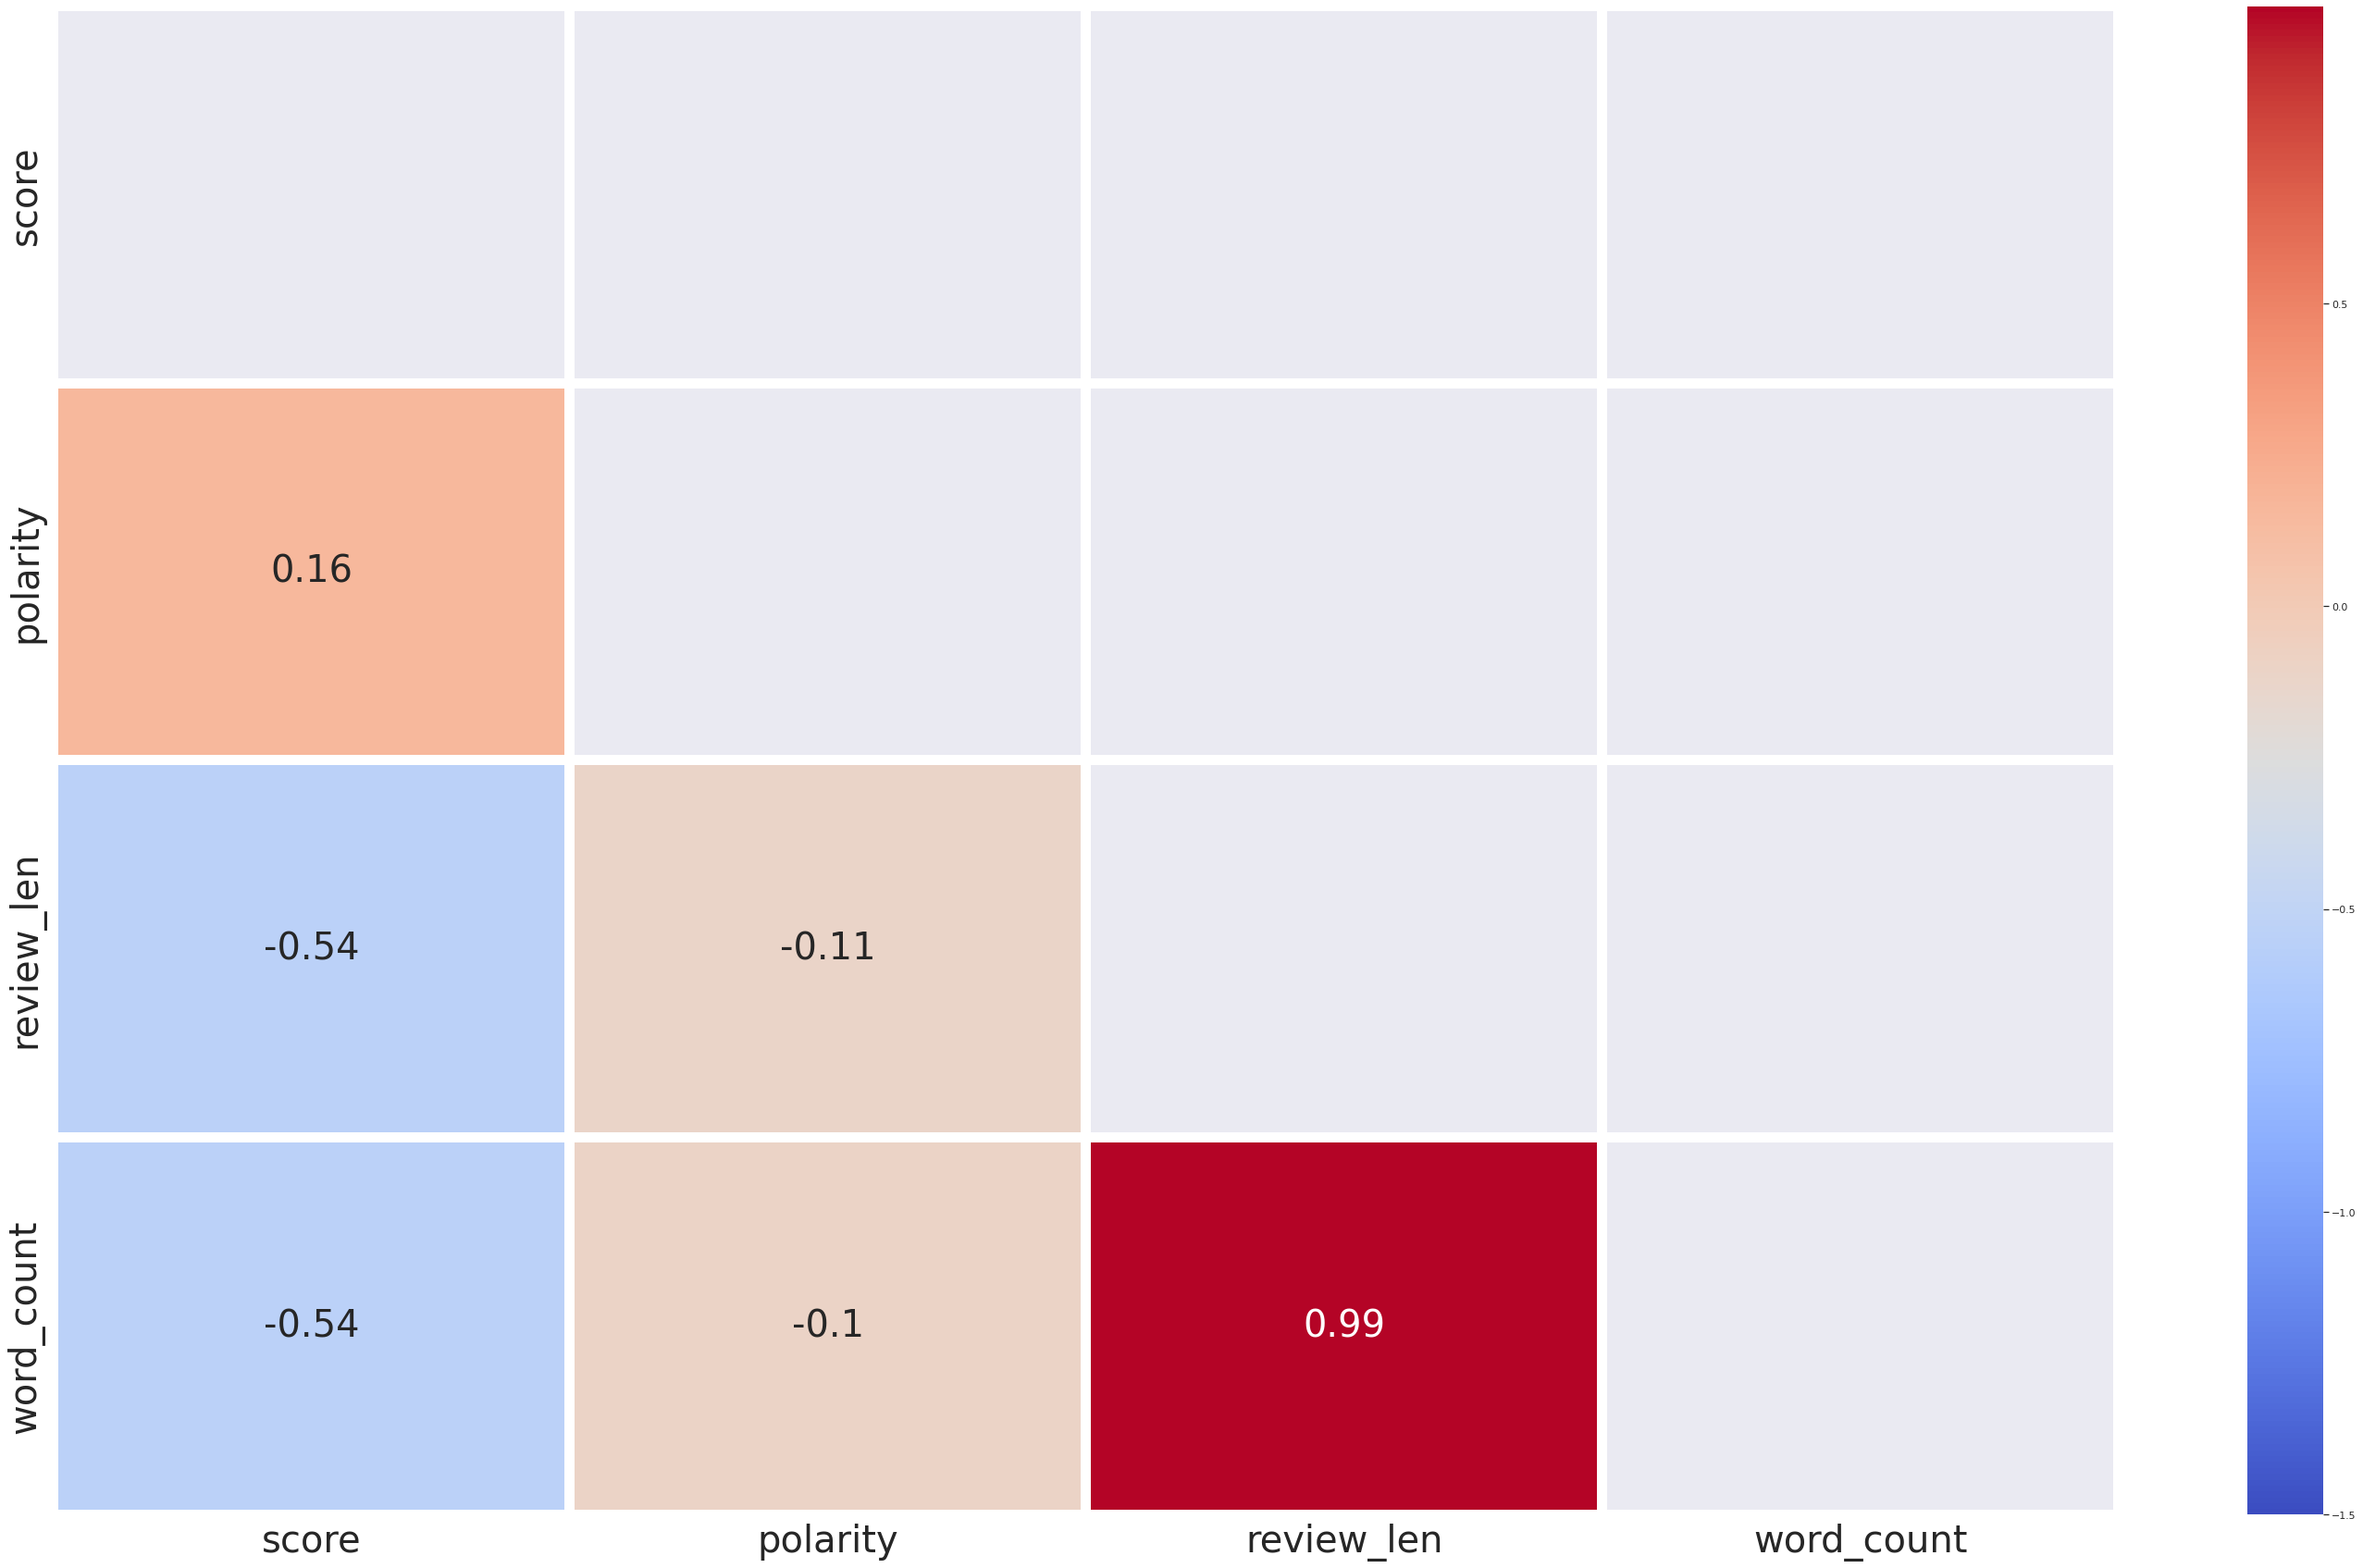

In [ ]:
## Creating a matrix correlation for the words and sentiment

correlation = table_temp[['score','polarity', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)
#sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask).savefig('map.png')

## **Vectorization and Tokenization**

The CountVectorizer method of vectorizing tokens transposes all the words/tokens into features and then provides a count of occurrence of each word. The result is called a document term matrix.

We are going to create a dataframe resulting from the vectorization. We will eliminate the words that are repeated less than 25% of the time in all reviews and also those that are repeated more than 90%.


## **Detecting topics in our reviews.**

An important part of examining the reviews inside is detecting opportunities for improvement. For this we need to classify the reviews in different topics, for them algorithms like LDA (Latent Dirichlet Allocation) can help us.

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=50000) #using count vectorizer

tf = tf_vectorizer.fit_transform(table_temp['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()

doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

""" We started the development of our LDA algorithm. """

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=50, random_state=0).fit(tf)
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:
tarjeta app dinero veces rappi deja solo si hace ma
Topic 1:
pedido bueno promociones soporte ahora encanta buenas dia llego llegan
Topic 2:
rapido atencion usar cliente prime facil precios genial buenos puede
Topic 3:
siempre pesimo mal recomiendo cupones entrega cobertura sirve precio casi
Topic 4:
servicio excelente buen app exelente va queda sistema apuros negocios
Topic 5:
ma si tiempo envio gusta cobran restaurantes llega domicilio costo
Topic 6:
mejor nunca hacer pedidos pesima vez estan peso si puedo
Topic 7:
buena app dan momento verdad problema ningun problemas solucion delivery
Topic 8:
rappi pagar mala pago experiencia peor asi opcion hacen efectivo
Topic 9:
aplicacion bien buena comida pedir super funciona opciones luego falta


In [ ]:
## Another approach that we can achieve is using TFIDF

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(table_temp['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
 
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


Topic 0:
excelente servicio atencion opcion experiencia plataforma gracias promociones siempre servicios
Topic 1:
buena atencion experiencia opcion rapida rapido app general calidad plataforma
Topic 2:
servicio buen rapido pesimo siempre promociones cliente atencion tiempo mal
Topic 3:
bien funciona ahora siempre momento gracias pedidos veces general si
Topic 4:
app mejor gusta comida pedir pedidos ma pedido si usar
Topic 5:
bueno rapido servicio ta siempre caro veces ma rappi solo
Topic 6:
aplicacion mejor gusta pedido comida pedidos ma pesima promociones pedir
Topic 7:
exelente servicio promociones atencion gracias recomendable aplicasion calidad rapido buenas
Topic 8:
super encanta rapido rappi facil siempre promociones usar buenas eficiente
Topic 9:
genial rappi siempre promociones gusta ma gracias tarjeta experiencia parece


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


## **Saving the dataframe into Cloud Storage Bucket**

For the end we are going to save our information and leave it inside google cloud storage.

In this way, we can use it to generate our dashboards in the future.

In [ ]:
file_json = '<namefile>.json' #your service accounts credentials json format
project_id = '<project id>' # your project id


credentials = service_account.Credentials.from_service_account_file(file_json)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = file_json

client = storage.Client(credentials = credentials, project = project_id)

f = StringIO()
test.to_csv(f)
f.seek(0)

client.get_bucket('<bucket name>').blob('path/' + 'test1.csv').upload_from_file(f, content_type='text/csv')
print('End of code')

In [ ]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.3.0
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.2.0
audioread==2.1.9
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.3
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.4
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.3
dlib==19.18.0
dm-tree==0.1.5
docopt==0.6.2
docutil